# Vanilla GAN(Generative Adversarial Network)

In [1]:
import warnings
warnings.filterwarnings('ignore')

> ## Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers import LeakyReLU

# I. Load MNIST Dataset

* 'generator'의 'tanh' Activation 출력에 적합하도록 정규화

In [3]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
    
# Normalization
X_train = X_train.astype(np.float32) / 127.5 - 1
    
# Reshape
X_train = X_train.reshape(60000, 784)

11490434/11490434 [==============================] - 0s 0us/step


# II. 'adam' Optimizer

In [4]:
from tensorflow.keras.optimizers import Adam

adam = Adam(lr = 0.0002)

# III. 'generator' Model

* 랜덤 벡터(잠재공간의 랜덤 포인트)를 입력받아 이미지 생성
 - NOISE_DIM : 입력 랜덤 벡터 크기
* 'discriminator'를 속이도록 학습
 - 'Real Image'와 같은 'Fake Image' 생성이 목적

In [5]:
NOISE_DIM = 10

generator = Sequential(name = 'generator')

generator.add(Dense(256, input_shape = (NOISE_DIM,)))
generator.add(LeakyReLU())
generator.add(Dense(512))
generator.add(LeakyReLU())
generator.add(Dense(1024))
generator.add(LeakyReLU())
generator.add(Dense(784, activation = 'tanh'))

* Model Summary

In [6]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2816      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)               80

# IV. 'discriminator' Model

* 이미지를 입력받아 'Real Image'인지 'generator'가 생성한 'Fake Image' 인지 판별
 - 이진분류

In [7]:
from tensorflow.keras.initializers import RandomNormal

discriminator = Sequential(name = 'discriminator')

discriminator.add(Dense(1024, 
                        input_shape = (784,), 
                        kernel_initializer = RandomNormal(stddev = 0.02)))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.5))
discriminator.add(Dense(1, activation = 'sigmoid'))

* Model Summary

In [8]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)             

> ## 1) 'discriminator' Compile

* 학습 설정

In [9]:
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = adam)

# V. 'gan' Model

> ## 1) 'generator', 'discriminator' 연결

* 'gan' 모델에서 'generator'만 학습하도록 설정
 - discriminator.trainable = False

In [10]:
discriminator.trainable = False

gan_input = Input(shape = (NOISE_DIM,))
x = generator(gan_input)
output = discriminator(x)

> ## 2) 'gan' Model

In [11]:
gan = Model(gan_input, output, name = 'gan')

> ## 3) 'gan' Summary

In [12]:
gan.summary()

Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 generator (Sequential)      (None, 784)               1463312   
                                                                 
 discriminator (Sequential)  (None, 1)                 1460225   
                                                                 
Total params: 2,923,537
Trainable params: 1,463,312
Non-trainable params: 1,460,225
_________________________________________________________________


> ## 4) 'gan' Compile

* 학습 설정

In [13]:
gan.compile(loss = 'binary_crossentropy', 
            optimizer = adam)

# VI. Define 'get_batches( )' Function

* MNIST image batch 생성

In [14]:
def get_batches(data, batch_size):
    batches = []

    for i in range(data.shape[0] // batch_size):
        batch = data[i * batch_size : (i + 1) * batch_size]
        batches.append(batch)
    return np.asarray(batches)

# VII. 'visualize_training( )' Function

In [15]:
def visualize_training(epoch, d_losses, g_losses):

    # 오차 시각화
    # plt.figure(figsize=(8, 4))
    # plt.plot(d_losses, label='Discriminator Loss')
    # plt.plot(g_losses, label='Generatror Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()
    # print('epoch: {}, Discriminator Loss: {}, Generator Loss: {}'.format(epoch, np.asarray(d_losses).mean(), np.asarray(g_losses).mean()))
    
    # 이미지 생성 결과 시각화
    print('epoch :', epoch)
    noise = np.random.normal(0, 1, size = (24, NOISE_DIM))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(-1, 28, 28)
    
    plt.figure(figsize = (8, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 6, i + 1)
        plt.imshow(generated_images[i], interpolation = 'nearest', cmap = 'Greys_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# VIII. Model Training

* 약 60분
<br>
<br>
* .fit( )
 - 'epoch', 'batch_size' 지정
* .train_on_batch( )
 - 전달 받은 모든 데이터를 사용하여 학습 진행
* 'generator'가 매번 새로운 'Fake Image'를 생성하여 '.train_on_batch( )' 사용

epoch : 1
1/1 [==============================] - 0s 46ms/step


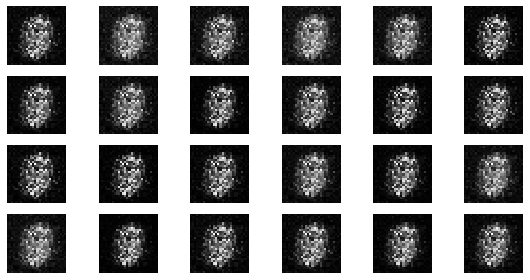

epoch : 5
1/1 [==============================] - 0s 18ms/step


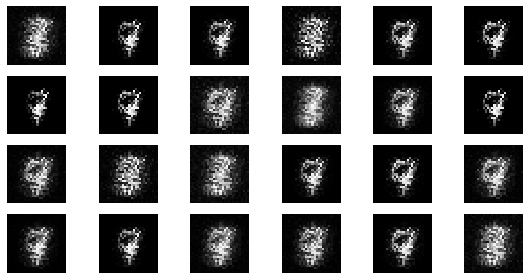

epoch : 10
1/1 [==============================] - 0s 14ms/step


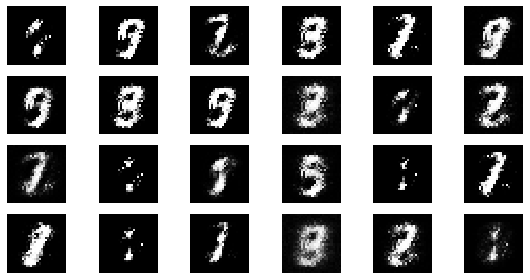

epoch : 15
1/1 [==============================] - 0s 14ms/step


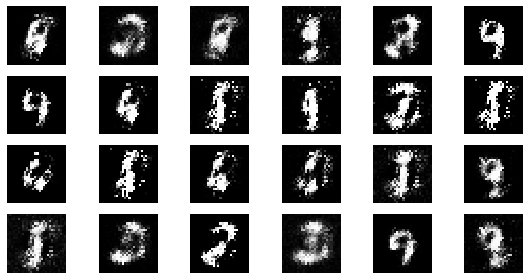

epoch : 20
1/1 [==============================] - 0s 17ms/step


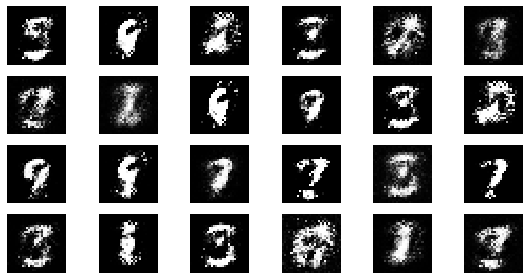

epoch : 25
1/1 [==============================] - 0s 14ms/step


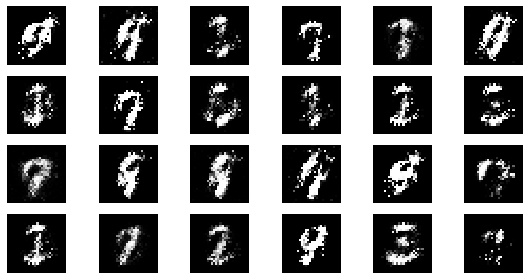

epoch : 30
1/1 [==============================] - 0s 14ms/step


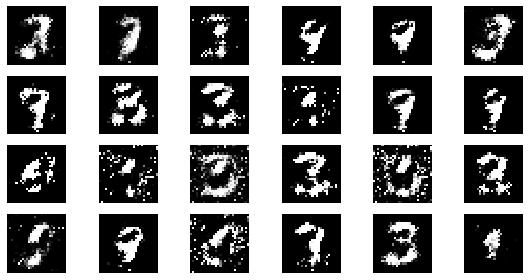

epoch : 35
1/1 [==============================] - 0s 17ms/step


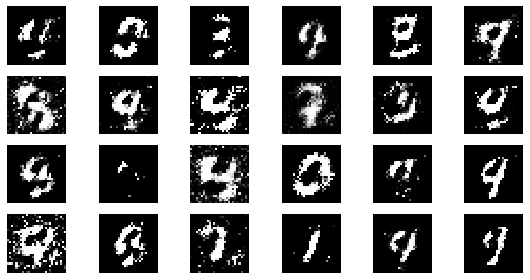

epoch : 40
1/1 [==============================] - 0s 19ms/step


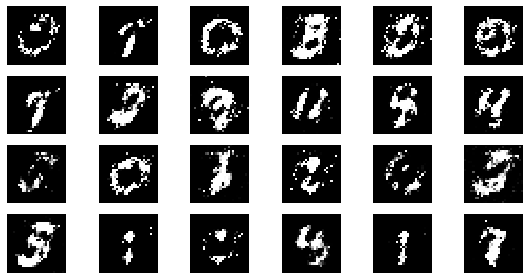

epoch : 45
1/1 [==============================] - 0s 19ms/step


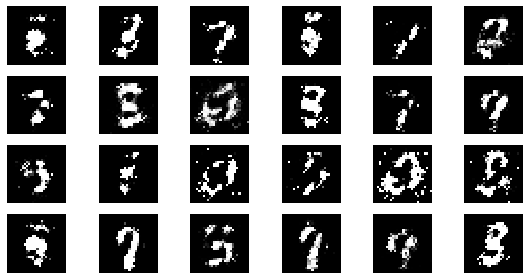

epoch : 50
1/1 [==============================] - 0s 14ms/step


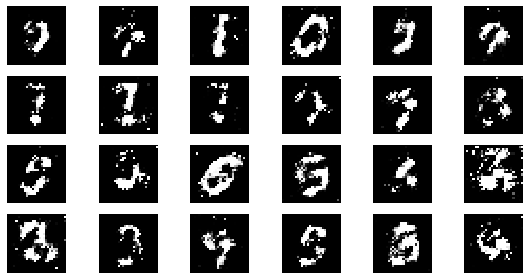

epoch : 55
1/1 [==============================] - 0s 14ms/step


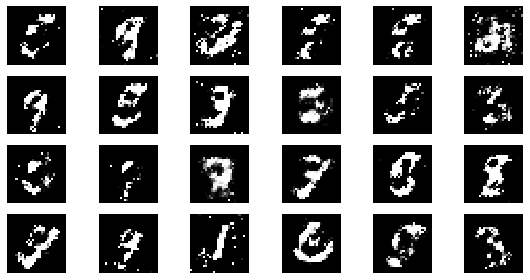

epoch : 60
1/1 [==============================] - 0s 15ms/step


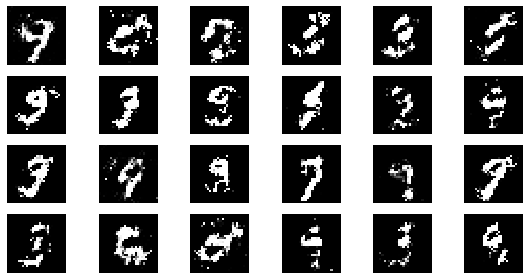

epoch : 65
1/1 [==============================] - 0s 14ms/step


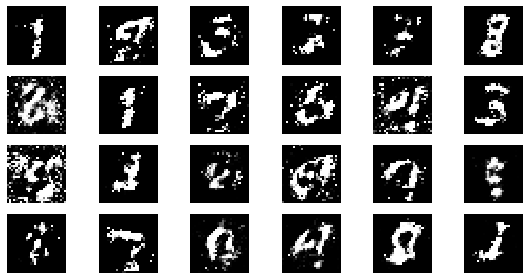

epoch : 70
1/1 [==============================] - 0s 14ms/step


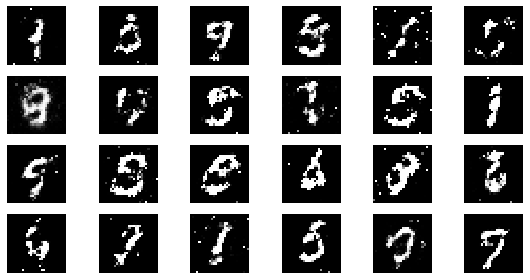

epoch : 75
1/1 [==============================] - 0s 13ms/step


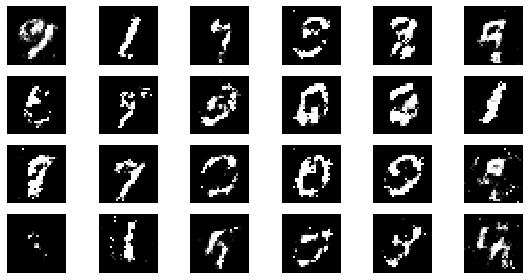

epoch : 80
1/1 [==============================] - 0s 13ms/step


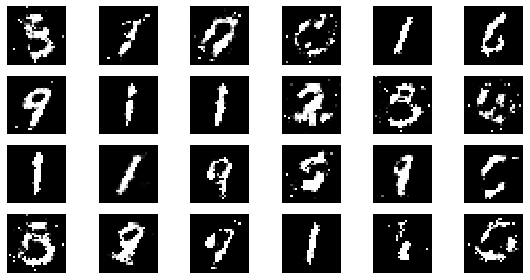

epoch : 85
1/1 [==============================] - 0s 13ms/step


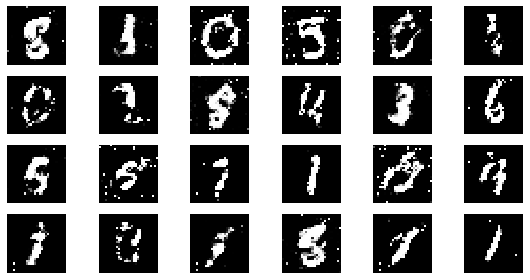

epoch : 90
1/1 [==============================] - 0s 14ms/step


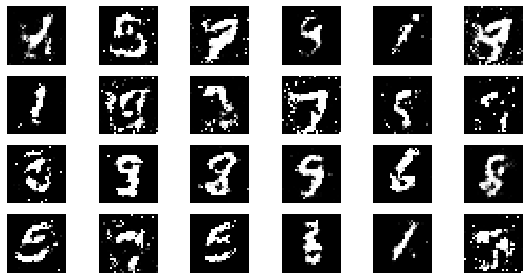

epoch : 95
1/1 [==============================] - 0s 14ms/step


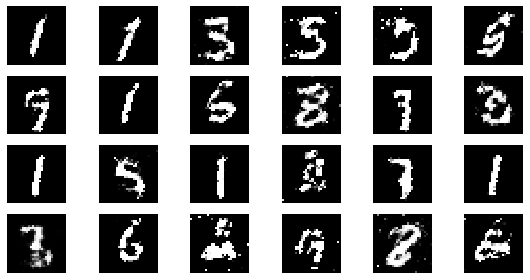

epoch : 100
1/1 [==============================] - 0s 15ms/step


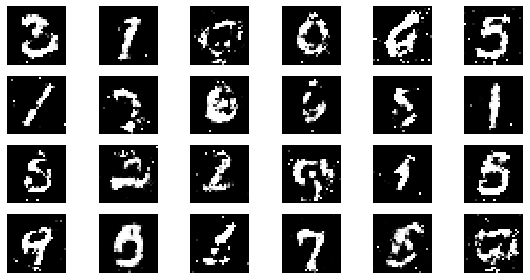

CPU times: user 42min 44s, sys: 2min 25s, total: 45min 10s
Wall time: 46min 32s


In [16]:
%%time

EPOCHS = 100
BATCH_SIZE = 128

# 'discriminator', 'gan' Loss 저장 List
d_losses = []
g_losses = []

for epoch in range(1, EPOCHS + 1):
    # batch 별 학습
    for real_images in get_batches(X_train, BATCH_SIZE):
        # Random Noise 생성
        input_noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        
        # Fake Image 데이터 생성
        generated_images = generator.predict(input_noise, verbose = 0)
        
        # 'discriminator' 학습용 X 데이터 정의
        x_dis = np.concatenate([real_images, generated_images])
        
        # 'discriminator' 학습용 y 데이터 정의
        y_dis = np.zeros(2 * BATCH_SIZE)
        y_dis[:BATCH_SIZE] = 1
        
        # 'discriminator' 학습
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(x_dis, y_dis)
        
        # 'discriminator' 학습 정지
        discriminator.trainable = False

        # 'generator' 학습용 X,y 데이터 생성
        noise = np.random.uniform(-1, 1, size = [BATCH_SIZE, NOISE_DIM])
        y_gan = np.ones(BATCH_SIZE)
        
        # 'gan(generator)' 학습
        g_loss = gan.train_on_batch(noise, y_gan)
        
    d_losses.append(d_loss)
    g_losses.append(g_loss)

    # 생성 결과 시각화
    if epoch == 1 or epoch % 5 == 0:
        visualize_training(epoch, d_losses, g_losses)

# 
# 
# 
# The End
# 
# 
# 